# Download PACE and VIIRS Chl-a (L3) and make regional plots

In [2]:
# %pip install "hypercoast[extra]"

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import hypercoast
import cmocean
import requests
import earthaccess

In [2]:
import sys
sys.path.append("../../scripts")
import PACEToolkit.regional_plot as regional_plot

In [3]:
# hypercoast.nasa_earth_login()

# Temporal range
temporal = ("2024-06-01", "2024-06-15")  
# results= hypercoast.search_pace_chla(temporal=temporal, 
#                                      bbox = bbox)
# hypercoast.download_nasa_data(results, "../../data/pace_chla")

In [4]:
files = "../../data/pace_chla/*nc"
array = hypercoast.read_pace_chla(files)
array

<xarray.DataArray 'chlor_a' (lat: 1800, lon: 3600, date: 15)> Size: 389MB
dask.array<transpose, shape=(1800, 3600, 15), dtype=float32, chunksize=(512, 1024, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float32 7kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * lon          (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
  * date         (date) <U10 600B '2024-06-01' '2024-06-02' ... '2024-06-15'
    spatial_ref  int64 8B 0
Attributes:
    long_name:      Chlorophyll Concentration, OCI Algorithm
    units:          lg(mg m^-3)
    standard_name:  mass_concentration_of_chlorophyll_in_sea_water
    valid_min:      0.001
    valid_max:      100.0
    reference:      Hu, C., Lee Z., and Franz, B.A. (2012). Chlorophyll-a alg...
    display_scale:  log
    display_min:    0.01
    display_max:    20.0
    date:           ['2024-06-01', '2024-06-02', '2024-06-03', '2024-06-04', ...

Plot the mean value of the period

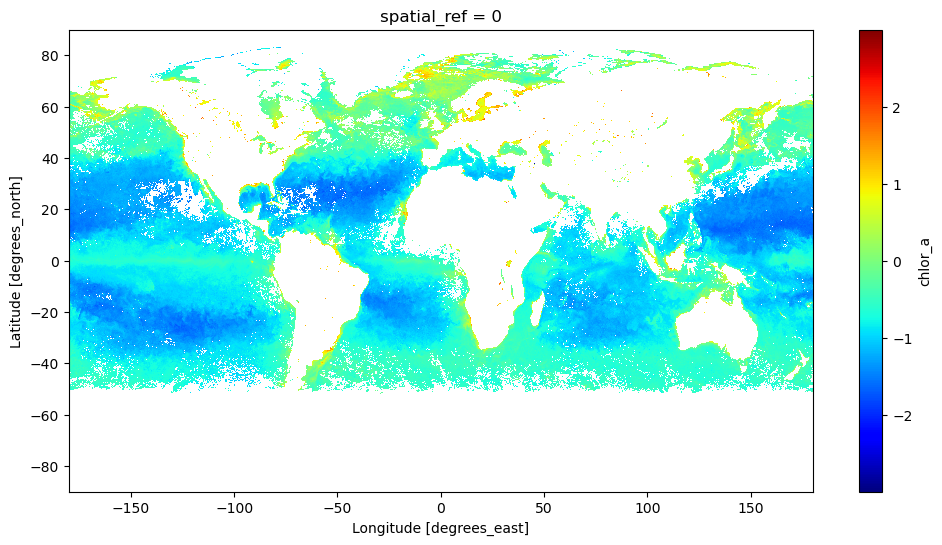

In [8]:
hypercoast.viz_pace_chla(array, cmap="jet", size=6)

### Custermize plots

In [5]:
# Calculate the mean of the 15-day data
array_mean = array.mean('date')
array_mean.attrs.update(
    {
        "long_name": array.attrs["long_name"],
        "units": f'lg({array.attrs["units"]})',
    }
)

In [6]:
# Define the boundary of the area
min_lon = -179     # lower left longitude
min_lat = 75     # lower left latitude !!! note the current lat is reversed, need to fix in the function
max_lon = -140     # upper right longitude
max_lat = 50     # upper right latitude

# Defining the boundaries
lon_bnds = [min_lon, max_lon]
lat_bnds = [min_lat, max_lat]

# Performing the reduction
array_mean_clip = array_mean.sel(lat=slice(*lat_bnds), lon=slice(*lon_bnds))

In [7]:
array_mean_clip

<xarray.DataArray 'chlor_a' (lat: 250, lon: 390)> Size: 390kB
dask.array<getitem, shape=(250, 390), dtype=float32, chunksize=(250, 390), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float32 1kB 74.95 74.85 74.75 74.65 ... 50.25 50.15 50.05
  * lon          (lon) float32 2kB -178.9 -178.9 -178.8 ... -140.2 -140.1 -140.1
    spatial_ref  int64 8B 0
Attributes:
    long_name:  Chlorophyll Concentration, OCI Algorithm
    units:      lg(lg(mg m^-3))

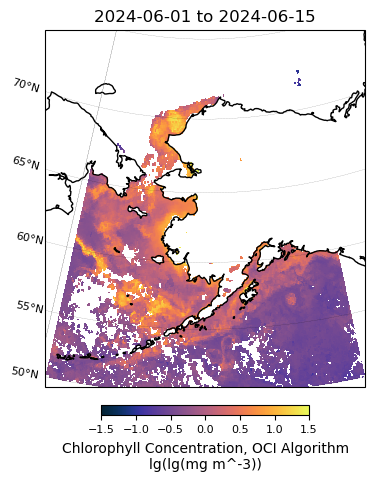

In [8]:
# Plot PACE data
m = regional_plot.plot_regional_map(array_mean_clip, min_lon, max_lon, min_lat, max_lat, 
                 title='{} to {}'.format(temporal[0],temporal[1]), 
                 vmin=-1.5, vmax=1.5, size=(5,5))

In [9]:
del array

## Load and plot VIIRS data

There are many different ways to obtain L3 data (e.g., from https://oceancolor.gsfc.nasa.gov/l3/) \
Here we show how to get data from NOAA's ERDDAP server (https://oceanwatch.pifsc.noaa.gov/erddap/index.html)

In [10]:
### Uncomment the following lines if you need to download the data for the first time

# import urllib.request 
# url = 'https://oceanwatch.pifsc.noaa.gov/erddap/griddap/noaa_snpp_chla_daily.nc?chlor_a%5B(2024-06-01T12:00:00Z):1:(2024-06-15T12:00:00Z)%5D%5B(0.0):1:(0.0)%5D%5B(77.00625):1:(50.006249999999994)%5D%5B(180.01875):1:(221.98125000000002)%5D'
# urllib.request.urlretrieve(url, "viirs.nc")

In [11]:
viirs_ds = xr.open_dataset('../../data/viirs.nc')

In [12]:
viirs_chla = np.log10(viirs_ds['chlor_a'])
# Calculate the temporal mean
viirs_chla_mean = viirs_chla.mean('time')

viirs_chla_mean.attrs.update(
    {
        "long_name": "SNPP VIIRS, L3 Chlorophyll a Concentration",
        "units": 'lg[lg[{}]]'.format(viirs_ds['chlor_a'].attrs["units"]),
    }
)

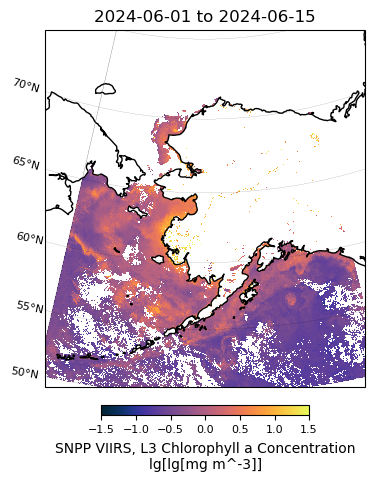

In [13]:
# Plot VIIRS data
m = regional_plot.plot_regional_map(viirs_chla_mean, min_lon, max_lon, min_lat, max_lat, 
                 title='{} to {}'.format(temporal[0],temporal[1]), 
                 vmin=-1.5, vmax=1.5, size=(5,5))

In [14]:
del viirs_ds

## Download and plot MODIS data

You will want to visit [NASA Earthdata Search](https://search.earthdata.nasa.gov/) and enter the short names to read about each data collection. We want to use the `MODISA_L3m_CHL` data collection for our plot. You can retrieve the files (granules) in that collection using `earthaccess.search_data()`.

In [17]:
auth = earthaccess.login(persist=True)

tspan = ("2023-06-01", "2023-06-15")
results = earthaccess.search_data(
    short_name="MODISA_L3m_CHL",
    granule_name="*.8D*.9km*",
    temporal=tspan,
)

In [18]:
results[0]

Collection: {'Version': 'R2022.0', 'ShortName': 'MODISA_L3m_CHL'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'NorthBoundingCoordinate': 90, 'SouthBoundingCoordinate': -90, 'EastBoundingCoordinate': 180, 'WestBoundingCoordinate': -180}]}}}
Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2023-06-01T23:59:59Z', 'BeginningDateTime': '2023-05-25T00:00:00Z'}}
Size(MB): 10.132624626159668
Data: ['https://oceandata.sci.gsfc.nasa.gov/cmr/getfile/AQUA_MODIS.20230525_20230601.L3m.8D.CHL.chlor_a.9km.nc']

By checking the first data, it indicates that the file is not cloud-hosted. We will need to download the data file with `earthaccess.download()`.

In [19]:
# paths = earthaccess.download(results, "../../data/modis_chla")

In [20]:
paths = [
    '../../data/modis_chla/AQUA_MODIS.20230525_20230601.L3m.8D.CHL.chlor_a.9km.nc',
    '../../data/modis_chla/AQUA_MODIS.20230602_20230609.L3m.8D.CHL.chlor_a.9km.nc',
    '../../data/modis_chla/AQUA_MODIS.20230610_20230617.L3m.8D.CHL.chlor_a.9km.nc'
]

In [21]:
modis_ds = xr.open_mfdataset(
    paths,
    combine="nested",
    concat_dim="date",
)
modis_ds

<xarray.Dataset> Size: 112MB
Dimensions:  (date: 3, lat: 2160, lon: 4320, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 9kB 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
  * lon      (lon) float32 17kB -180.0 -179.9 -179.8 ... 179.8 179.9 180.0
Dimensions without coordinates: date, rgb, eightbitcolor
Data variables:
    chlor_a  (date, lat, lon) float32 112MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    palette  (date, rgb, eightbitcolor) uint8 2kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/64)
    product_name:                      AQUA_MODIS.20230525_20230601.L3m.8D.CH...
    instrument:                        MODIS
    title:                             MODISA Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          Aqua
    source:                            satellite observations from MODIS-Aqua
    ...                                ...
    identifier_product_doi:            10.5067/AQUA/MODIS/L3M/CHL/2022
    keywords:                          Earth Science > Oceans > Ocean Chemist...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         3087431
    data_minimum:                      0.0031313652
    data_maximum:                      86.3219

In [32]:
modis_chla = np.log10(modis_ds["chlor_a"])
modis_chla_mean = modis_chla.mean('date')
modis_chla_mean.attrs.update(
    {
        "long_name": f'MODIS {modis_ds["chlor_a"].attrs["long_name"]}',
        "units": f'log({modis_ds["chlor_a"].attrs["units"]})',
    }
)

In [33]:
# Performing the reduction
modis_chla_mean_clip = modis_chla_mean.sel(lat=slice(*lat_bnds), lon=slice(*lon_bnds))

In [34]:
modis_chla_mean_clip

<xarray.DataArray 'chlor_a' (lat: 300, lon: 468)> Size: 562kB
dask.array<getitem, shape=(300, 468), dtype=float32, chunksize=(300, 468), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 1kB 74.96 74.88 74.79 74.71 ... 50.21 50.12 50.04
  * lon      (lon) float32 2kB -179.0 -178.9 -178.8 ... -140.2 -140.1 -140.0
Attributes:
    long_name:  MODIS Chlorophyll Concentration, OCI Algorithm
    units:      log(mg m^-3)

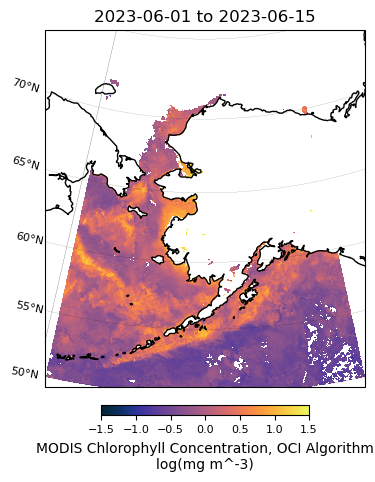

In [35]:
# Plot MODIS data
m = regional_plot.plot_regional_map(modis_chla_mean_clip, min_lon, max_lon, min_lat, max_lat, 
                 title='{} to {}'.format(tspan[0],tspan[1]), 
                 vmin=-1.5, vmax=1.5, size=(5,5))

## Now let's put them side by side

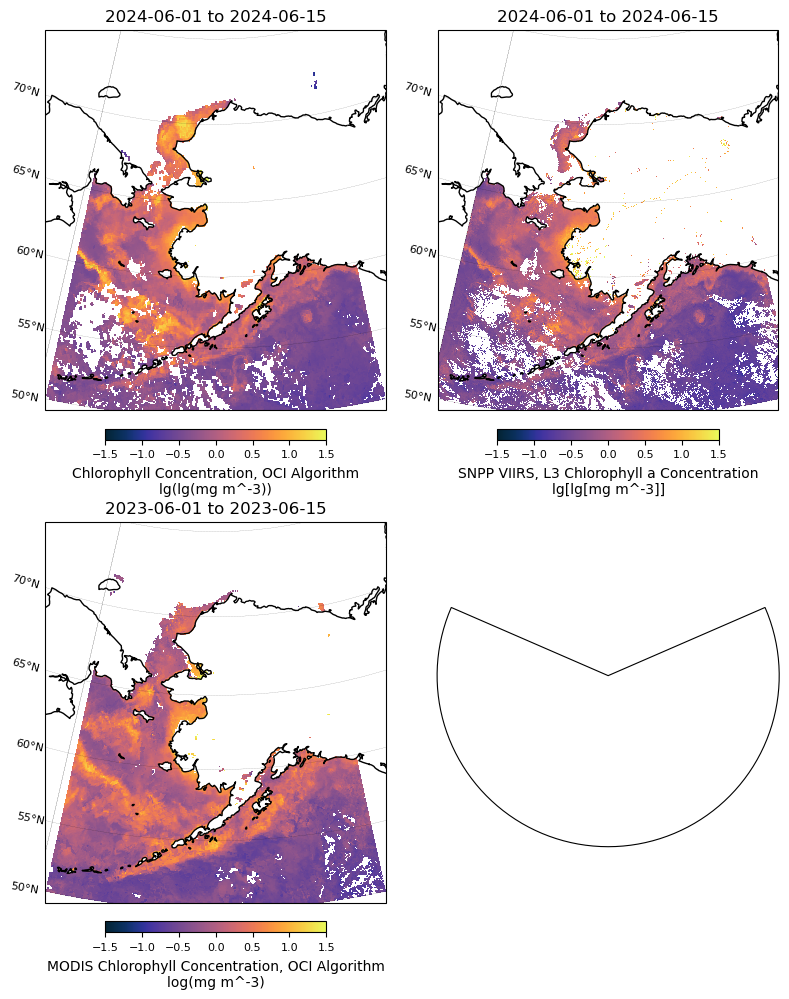

In [38]:
# Calculate central longitude and latitude
central_longitude = (min_lon + max_lon) / 2
central_latitude = (min_lat + max_lat) / 2

# Define project
projection = ccrs.LambertConformal(central_longitude=central_longitude, 
                                   central_latitude=central_latitude)

fig, axs = plt.subplots(2, 2, figsize=(8, 10), 
                        subplot_kw={'projection': projection})

m1 = regional_plot.plot_regional_map(array_mean_clip, min_lon, max_lon, min_lat, max_lat, 
                 title='{} to {}'.format(temporal[0],temporal[1]), 
                 vmin=-1.5, vmax=1.5, ax=axs[0, 0])

m2 = regional_plot.plot_regional_map(viirs_chla_mean, min_lon, max_lon, min_lat, max_lat, 
                 title='{} to {}'.format(temporal[0],temporal[1]), 
                 vmin=-1.5, vmax=1.5, ax=axs[0, 1])

m3 = regional_plot.plot_regional_map(modis_chla_mean_clip, min_lon, max_lon, min_lat, max_lat, 
                 title='{} to {}'.format(tspan[0],tspan[1]), 
                 vmin=-1.5, vmax=1.5, ax=axs[1, 0])

fig.tight_layout()